In [1]:
#check gpu
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt 

# Load and Preprocess Data
csv_path = 'data-vn-20230228\stock-historical-data'

keywords = [
    "ABB", "ACB", "BID", "CTG", "EIB", "BVB", "HDB", "KLB", "LPB", "MBB", "MSB",
    "NAB", "BAB", "NVB", "OCB", "PGB", "SSB", "SGB", "SHB", "STB", "TCB", "TPB",
    "VAB", "VCB", "VIB", "VPB", "VBB"
]

# Load data
df_list = []
for file in os.listdir(csv_path):
    if any(keyword in file for keyword in keywords) and file.endswith('.csv'):
        file_path = os.path.join(csv_path, file)
        data = pd.read_csv(file_path, on_bad_lines='skip').dropna()
        data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
        df_list.append(data)

# Drop rows with missing values due to rolling calculations
df_list = [df.dropna().reset_index(drop=True) for df in df_list]

# Split into Train, Validation, and Test Sets
split_date_train = pd.Timestamp('2020-01-01')
split_date_val = pd.Timestamp('2021-01-01')
split_date_buffer = pd.Timestamp('2021-02-01')  # Buffer period

df_train_list, df_val_list, df_test_list = [], [], []
for df in df_list:
    train = df.loc[df['TradingDate'] < split_date_train]
    temp_test = df.loc[df['TradingDate'] >= split_date_train]
    val = temp_test.loc[temp_test['TradingDate'] < split_date_val]
    test = temp_test.loc[temp_test['TradingDate'] >= split_date_buffer]
    df_train_list.append(train)
    df_val_list.append(val)
    df_test_list.append(test)

C:\Users\nhata\AppData\Local\Temp\ipykernel_13464\2686427793.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_13464\2686427793.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_13464\2686427793.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_13464\2686427793.py:25: UserWarning

In [3]:
from tqdm import tqdm
import numpy as np

# Function to split a dataset into time windows with tqdm progress bar
def create_time_window_samples(df_list, window_size=30):
    X_data = []
    y_data = []

    # Wrap tqdm around the main loop to track progress
    for df in tqdm(df_list, desc="Processing DataFrames"):
        for i in range(0, len(df) - window_size):
            current_feature = []

            # Get a window_size time frame for data features
            for j in range(window_size):
                # Concatenate all 5 features: Open, High, Low, Close, Volume
                data_feature = [df.iloc[i + j, k] for k in range(1, 6)]
                current_feature.append(np.array(data_feature))

            # Next value is the label (price of the next day) to be predicted
            data_label = df.iloc[i + window_size, 1]  # 'Open' price is at index 1

            # Append new data sample (feature and label) to X_data and y_data
            X_data.append(np.array(current_feature).reshape(window_size, 5))
            y_data.append(data_label)

    return np.array(X_data), np.array(y_data)

# Define the window size
window_size = 30

# Generate training, validation, and test samples with progress bars
X_data_train, y_data_train = create_time_window_samples(df_train_list, window_size)
X_data_val, y_data_val = create_time_window_samples(df_val_list, window_size)
X_data_test, y_data_test = create_time_window_samples(df_test_list, window_size)

# Print confirmation
print("Data samples created for training, validation, and test sets.")

Processing DataFrames: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]

Data samples created for training, validation, and test sets.


In [4]:
# Function to normalize data with Min-Max scaling
def min_max_normalize(X_data, y_data=None):
    print("Normalizing data with Min-Max scaling...")
    X_norm = X_data.copy()
    y_norm = y_data.copy() if y_data is not None else None

    for i in range(len(X_data)):
        for j in range(X_data.shape[2]):
            min_feature = np.min(X_data[i][:, j])
            max_feature = np.max(X_data[i][:, j])
            X_norm[i][:, j] = (X_data[i][:, j] - min_feature) / (max_feature - min_feature) if max_feature > min_feature else 0
        if (i+1) % 100 == 0 or i == len(X_data) - 1:  # Print progress every 100 samples
            print(f"Processed normalization for sample {i+1}/{len(X_data)}")

    if y_data is not None:
        for i in range(len(y_data)):
            min_label = np.min(X_data[i][:, 1])
            max_label = np.max(X_data[i][:, 1])
            y_norm[i] = (y_data[i] - min_label) / (max_label - min_label) if max_label > min_label else 0

    print("Normalization complete.")
    return X_norm, y_norm

# Normalize training, validation, and test data
X_train_norm, y_train_norm = min_max_normalize(X_data_train, y_data_train)
X_val_norm, y_val_norm = min_max_normalize(X_data_val, y_data_val)
X_test_norm, y_test_norm = min_max_normalize(X_data_test, y_data_test)

Normalizing data with Min-Max scaling...
Processed normalization for sample 100/22201
Processed normalization for sample 200/22201
Processed normalization for sample 300/22201
Processed normalization for sample 400/22201
Processed normalization for sample 500/22201
Processed normalization for sample 600/22201
Processed normalization for sample 700/22201
Processed normalization for sample 800/22201
Processed normalization for sample 900/22201
Processed normalization for sample 1000/22201
Processed normalization for sample 1100/22201
Processed normalization for sample 1200/22201
Processed normalization for sample 1300/22201
Processed normalization for sample 1400/22201
Processed normalization for sample 1500/22201
Processed normalization for sample 1600/22201
Processed normalization for sample 1700/22201
Processed normalization for sample 1800/22201
Processed normalization for sample 1900/22201
Processed normalization for sample 2000/22201
Processed normalization for sample 2100/22201
Pr

In [5]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling1D

# Build the model architecture
model = tf.keras.Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(window_size, 5), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

In [6]:
# Compile and train the model with Mean Squared Error loss function
model.summary()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 32)             3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 32)             3

In [7]:
# evaluate the model
loss, mse = model.evaluate(X_test_norm, y_test_norm, verbose=0)
print('Test loss: %.3f' % loss)
print('Test mse: %.3f' % mse)

Test loss: 0.015
Test mse: 0.015


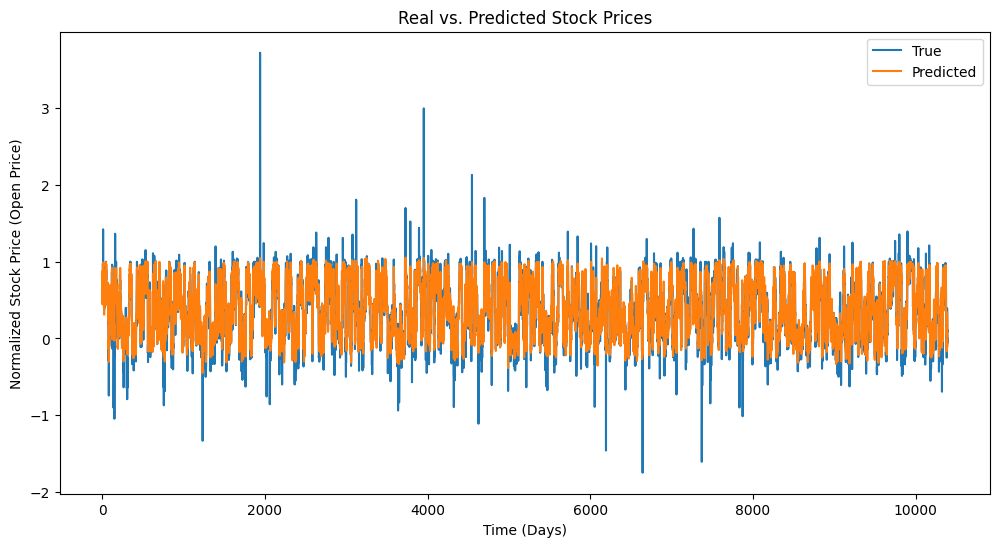

In [8]:
import matplotlib.pyplot as plt

# plot predictions
yhat = model.predict(X_test_norm)
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm, label='True')
plt.plot(yhat, label='Predicted')
plt.title('Real vs. Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.layers import LSTM, Flatten, Dense

# Build the LSTM model architecture
modelLSTM = tf.keras.Sequential()
modelLSTM.add(LSTM(50, return_sequences=True, input_shape=(window_size, 5)))  # First LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Dropout layer for regularization
modelLSTM.add(LSTM(50, return_sequences=False))  # Second LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Another Dropout layer for regularization
modelLSTM.add(Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelLSTM.add(Dense(1))  # Output layer for regression (predicting stock prices)

In [10]:
# Compile the model
modelLSTM.summary()
modelLSTM.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelLSTM.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 36,601
Trainable params: 36,601
Non-trainable params: 0
__________________________________________________

In [11]:
# evaluate the model
loss, mse = modelLSTM.evaluate(X_test_norm, y_test_norm, verbose=0)
print('Test loss: %.3f' % loss)
print('Test mse: %.3f' % mse)

Test loss: 0.017
Test mse: 0.017


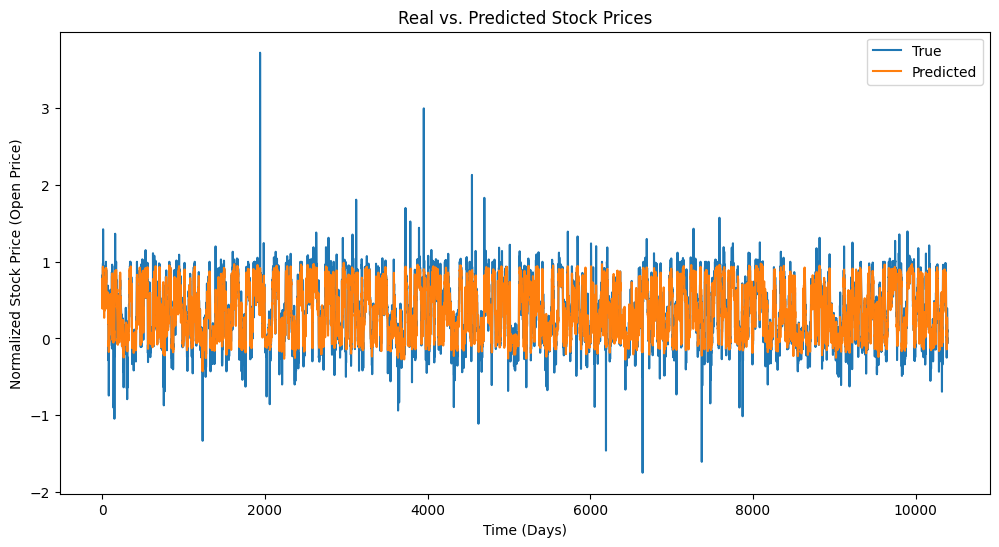

In [12]:
import matplotlib.pyplot as plt

# plot predictions
yhat = modelLSTM.predict(X_test_norm)
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm, label='True')
plt.plot(yhat, label='Predicted')
plt.title('Real vs. Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

In [13]:
# Build the GRU model architecture
modelGRU = tf.keras.Sequential()
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=True, input_shape=(window_size, 5)))  # First GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Dropout layer for regularization
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=False))  # Second GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Another Dropout layer for regularization
modelGRU.add(tf.keras.layers.Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelGRU.add(tf.keras.layers.Dense(1))  # Output layer for regression (predicting stock prices)

In [14]:
# Compile the model
modelGRU.summary()
modelGRU.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelGRU.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            13632     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 45,193
Trainable params: 45,193
Non-trainable params: 0
__________________________________________________

In [15]:
# evaluate the model
loss, mse = modelGRU.evaluate(X_test_norm, y_test_norm, verbose=0)
print('Test loss: %.3f' % loss)
print('Test mse: %.3f' % mse)

Test loss: 0.015
Test mse: 0.015


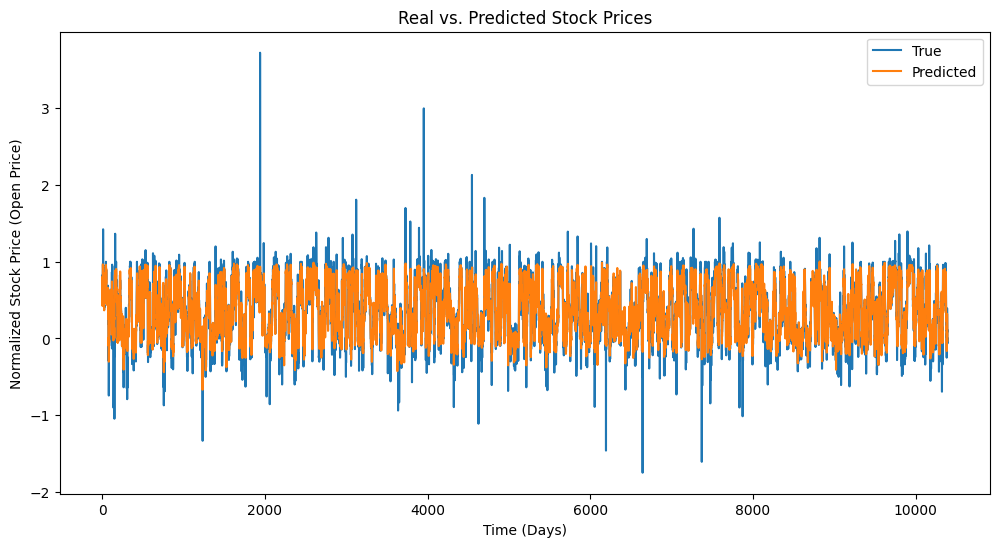

In [16]:
import matplotlib.pyplot as plt

# plot predictions
yhat = modelGRU.predict(X_test_norm)
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm, label='True')
plt.plot(yhat, label='Predicted')
plt.title('Real vs. Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

Using modelConv1D for prediction


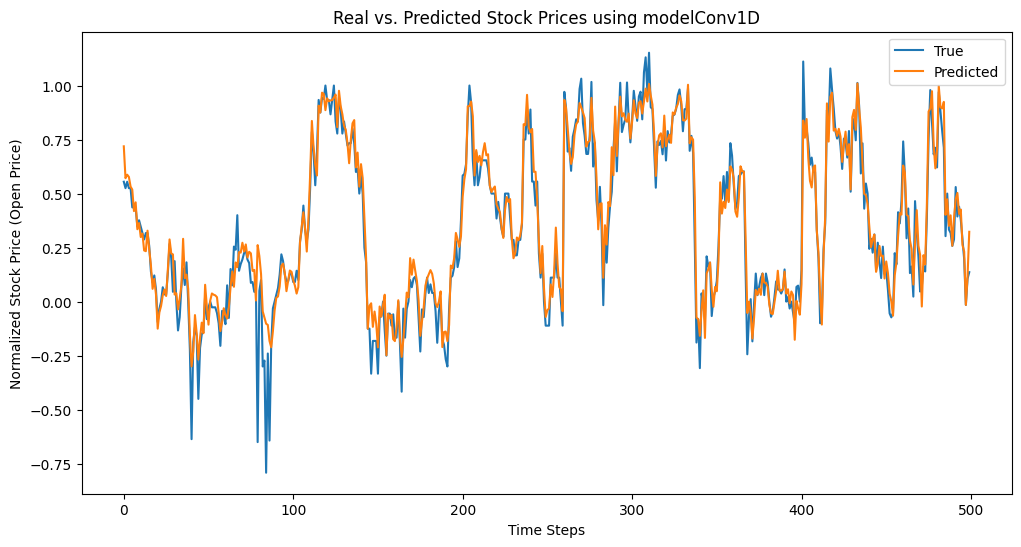

In [27]:
import random

models = {
    "modelConv1D": model,
    "modelLSTM": modelLSTM,
    "modelGRU": modelGRU
}

# Randomly select a model for prediction
selected_model_name = random.choice(list(models.keys()))
selected_model = models[selected_model_name]
print(f"Using {selected_model_name} for prediction")

# Select a random index from the list of DataFrames
random_index = random.randint(0, len(df_list) - 1)
random_file = df_list[random_index]  # Get the DataFrame
file_name = keywords[random_index]  # Get the corresponding file name
file_name_prefix = file_name[:3]  # Extract the first 3 letters

# Print the file name prefix
# print(f"Randomly selected company file prefix: {file_name_prefix}")

# Select a random index for plotting
random_index = random.randint(0, len(y_test_norm) - 500)

# Make predictions with the selected model
yhat = selected_model.predict(X_test_norm)

# Plot the real and predicted stock prices for the selected company
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[random_index:random_index + 500], label='True')
plt.plot(yhat[random_index:random_index + 500], label='Predicted')
plt.title(f"Real vs. Predicted Stock Prices using {selected_model_name}")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Stock Price (Open Price)")
plt.legend()
plt.show()